# Regression and Classification with the Ames Housing Data

---

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [169]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from feature_selector import FeatureSelector

import sys

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import RadViz

sys.setrecursionlimit(10000)

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Estimating the value of homes from fixed characteristics.

---

- Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
- Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
- Evaluate the mean dollar value of different renovations.

We can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

We have a dataset of housing sales data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
We need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components
---
### Data Cleaning & EDA

In [153]:
# Load the data
house = pd.read_csv('../housing.csv', keep_default_na=True)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
EDA_profile_reporter = house.profile_report()

### Saving EDA Profile Report to .html file for easier viewing

In [102]:
EDA_profile_reporter.to_file(output_file='EDA_profile_report.html')

In [29]:
house['LotFrontage'].fillna(value=0, inplace=True)
house['LotFrontage'].unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,   0.,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

#### Looking for Nulls

In [4]:
dict(house.isnull().sum())

{'Id': 0,
 'MSSubClass': 0,
 'MSZoning': 0,
 'LotFrontage': 0,
 'LotArea': 0,
 'Street': 0,
 'Alley': 1369,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 0,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 0,
 'Exterior2nd': 0,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinSF1': 0,
 'BsmtFinType2': 38,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 0,
 'TotRmsAbvGrd': 0,
 'Functional': 0,
 'Firep

#### Removing non-residential properties 

In [30]:
house.drop(house[house['MSZoning'] == 'C (all)'].index, inplace=True, axis=0)

#### Assigning fixed predictor variables for pricing, and target value of 'Sale Price'.

In [31]:
fixed = house[['MSZoning','LotFrontage', 'LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','MiscFeature']]
renovatable = house.drop(fixed,axis=1)
y = house['SalePrice'].values

#### Renaming MSSubClass, then realised that the data of this feature is included in other categories. 

In [7]:
MSSubClass_dict = { 20:'1-STORY 1946 & NEWER ALL STYLES',
                    30:'1-STORY 1945 & OLDER',
                    40:'1-STORY W/FINISHED ATTIC ALL AGES',
                    45:'1-1/2 STORY - UNFINISHED ALL AGES',
                    50:'1-1/2 STORY FINISHED ALL AGES',
                    60:'2-STORY 1946 & NEWER',
                    70:'2-STORY 1945 & OLDER',
                    75:'2-1/2 STORY ALL AGES',
                    80:'SPLIT OR MULTI-LEVEL',
                    85:'SPLIT FOYER',
                    90:'DUPLEX - ALL STYLES AND AGES',
                   120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                   150:'1-1/2 STORY PUD - ALL AGES',
                   160:'2-STORY PUD - 1946 & NEWER',
                   180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                   190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

#### Dropping features related to sale type from the renovatable class.

In [32]:
renovatable.drop(['Id','MoSold','YrSold','SaleType','SaleCondition'],axis=1)

,MSSubClass,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,SalePrice
0,60,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,...,0,61,0,0,0,0,NaN,NaN,0,208500
1,20,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,...,298,0,0,0,0,0,NaN,NaN,0,181500
2,60,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,...,0,42,0,0,0,0,NaN,NaN,0,223500
3,70,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,...,0,35,272,0,0,0,NaN,NaN,0,140000
4,60,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,...,192,84,0,0,0,0,NaN,NaN,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,...,0,40,0,0,0,0,NaN,NaN,0,175000
1456,20,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,...,349,0,0,0,0,0,NaN,MnPrv,0,210000
1457,70,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,...,0,60,0,0,0,0,NaN,GdPrv,2500,266500
1458,20,5,6,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,...,366,0,112,0,0,0,NaN,NaN,0,142125


#### Identifying string data type columns, that will later have get_dummies applied to them. 

In [33]:
fixed.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'GarageType', 'MiscFeature'],
      dtype='object')

#### Producing dummy columns for string data types, and keeping 'NA' values as these are part of the data. 

In [34]:
dummies = pd.get_dummies(fixed.select_dtypes(include=['object']), dummy_na=True)

#### Combining dummies with the original fixed predictor variables. 

In [35]:
long_fixed = pd.concat([fixed,dummies], axis=1, sort=True)
long_fixed

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,0,0,1
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,0,0,0,1
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,0,0,1
3,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,1,0,0,0,0,0,1
4,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,0,0,1
1456,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,0,0,1
1457,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,1,0,0
1458,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,0,0,0,1


#### To avoid duplicate data, dropping the original columns that the dummies were generated from. 

In [36]:
long_fixed.drop(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'GarageType', 'MiscFeature'], axis=1, inplace=True)

#### Checking that dummy_na=True worked during get_dummies processing. 

In [13]:
dict(long_fixed.isnull().sum())

{'LotFrontage': 0,
 'LotArea': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'BsmtFinSF1': 0,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 0,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'TotRmsAbvGrd': 0,
 'Fireplaces': 0,
 'GarageYrBlt': 79,
 'GarageCars': 0,
 'GarageArea': 0,
 'MSZoning_FV': 0,
 'MSZoning_RH': 0,
 'MSZoning_RL': 0,
 'MSZoning_RM': 0,
 'MSZoning_nan': 0,
 'Street_Grvl': 0,
 'Street_Pave': 0,
 'Street_nan': 0,
 'Alley_Grvl': 0,
 'Alley_Pave': 0,
 'Alley_nan': 0,
 'LotShape_IR1': 0,
 'LotShape_IR2': 0,
 'LotShape_IR3': 0,
 'LotShape_Reg': 0,
 'LotShape_nan': 0,
 'LandContour_Bnk': 0,
 'LandContour_HLS': 0,
 'LandContour_Low': 0,
 'LandContour_Lvl': 0,
 'LandContour_nan': 0,
 'Utilities_AllPub': 0,
 'Utilities_NoSeWa': 0,
 'Utilities_nan': 0,
 'LotConfig_Corner': 0,
 'LotConfig_CulDSac': 0,
 'LotConfig_FR2': 0,
 'LotConfig_FR3': 0,
 '

Dropping GarageYrBlt as this is unlikely to have much of an impact on the property value. 

In [37]:
long_fixed.drop('GarageYrBlt', inplace=True, axis=1)

Checking shape of traget and predictor data before applying modelling techniques. 

In [38]:
house.shape

(1450, 81)

In [39]:
long_fixed.shape

(1450, 145)

Checking target is normally distributed.

Text(0.5, 1.0, 'Sale Price Distribution')

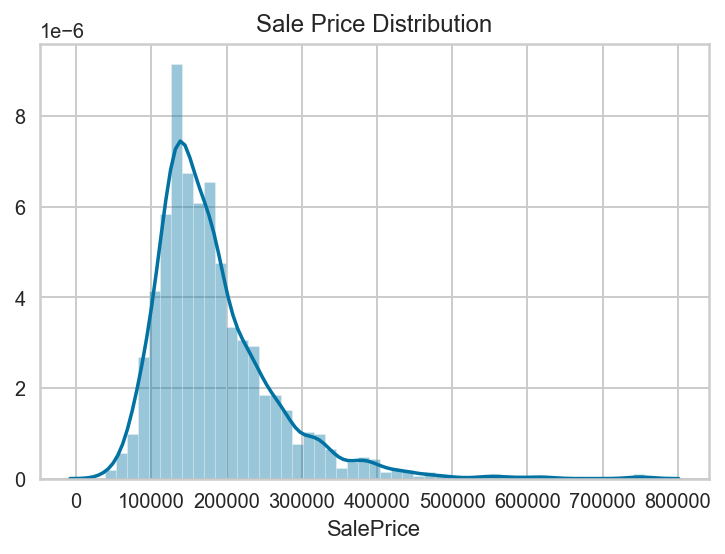

In [17]:
sns.distplot(house['SalePrice'] , norm_hist=True, )
plt.title('Sale Price Distribution')

#### Normalising target with `log1p`, as this maintains smaller values.

Text(0.5, 1.0, 'Sale Price Distribution')

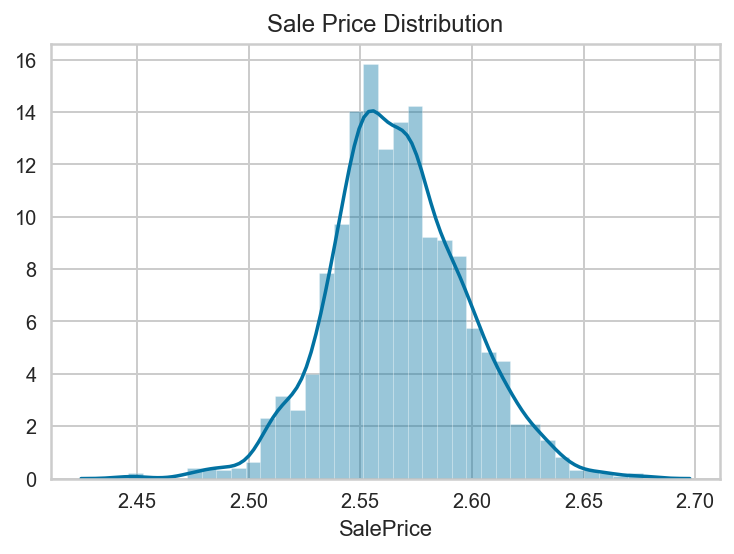

In [19]:
house["SalePrice"]=np.log1p(house["SalePrice"])
sns.distplot(house['SalePrice'] , norm_hist=True)
plt.title('Sale Price Distribution')

#### Creating index for houses sold before and during/after 2010, then training data on pre-2010 and testing or post-2010. 

In [40]:
train_index = house[house['YrSold'] < 2010].index
test_index = house[house['YrSold'] >= 2010].index

X_train = long_fixed.loc[train_index, :]
X_test = long_fixed.loc[test_index, :]
y_train = house.loc[train_index, 'SalePrice'].values
y_test = house.loc[test_index, 'SalePrice'].values

#### Standardising training and testing data as it includes binary dummies and regular data such as dates. 

In [41]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [42]:
Xs_train.shape

(1278, 145)

#### Creating baseline model score with Linear Regression

In [43]:
lr = LinearRegression(n_jobs=-1)

lr.fit(Xs_train, y_train)
print('All of the fixed property fixtures explain', (lr.score(Xs_test, y_test))*100,'% of variance in the `Sale Price` for homes sold pre-2010.')

All of the fixed property fixtures explain 87.46640904236438 % of variance in the `Sale Price` for homes sold pre-2010.


Text(0.5, 1.0, 'Actual vs. Predicted Home Values')

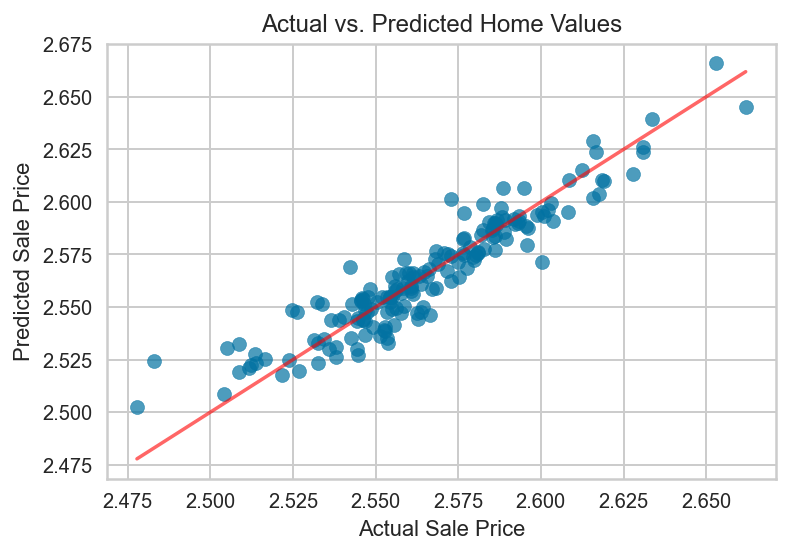

In [24]:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', alpha=0.6)
plt.scatter(y_test, lr.predict(Xs_test), alpha = .7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Home Values')

#### LassoCV with cv being statistical standard

In [44]:
lcv = LassoCV(cv=Xs_train.shape[0]-1, n_jobs=-1)

lcv.fit(Xs_train,y_train)
print('The LASSO REGRESSION model predicts', (lcv.score(Xs_test,y_test))*100,'% of the variance in `Sale Prices` on properties sold pre-2010.')

The LASSO REGRESSION model predicts 86.24201045224052 % of the variance in `Sale Prices` on properties sold pre-2010.


#### Plotting the Lassoed values

Text(0.5, 1.0, 'Actual vs. Predicted Home Values With Lassoed Features')

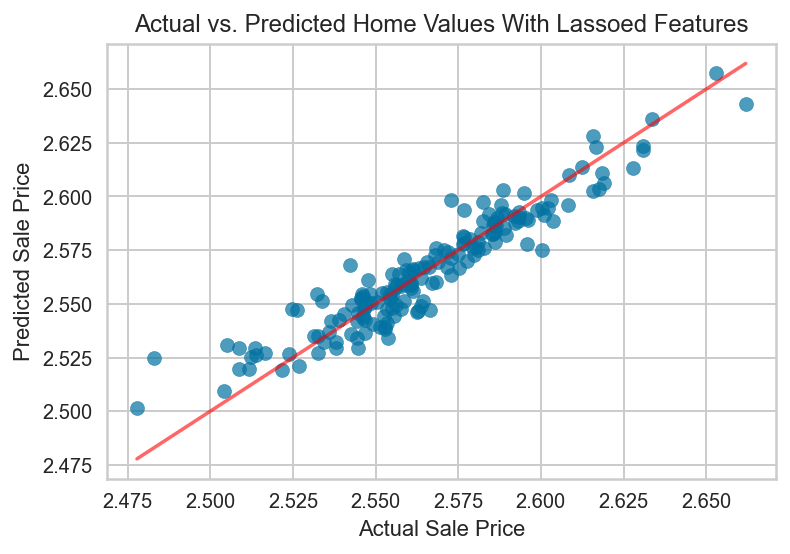

In [26]:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', alpha=0.6)
plt.scatter(y_test, lcv.predict(Xs_test), alpha = .7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Home Values With Lassoed Features')

#### Putting the fixed lassoed features/co-efficients into a sorted DataFrame, and removing the ones with 0 as a co-efficient value as these have no impact on the final sale price. 

In [45]:
fixed_coef = pd.DataFrame({'Fixed Features': long_fixed.columns, 'Co-efficients': lcv.coef_, "Absolute Co-efficients":np.abs(lcv.coef_)})

In [46]:
fixed_coef[fixed_coef['Absolute Co-efficients']!=0].shape

(38, 3)

#### Extracting and sorting the fixed features with absolute coefficients greater than 0.

In [47]:
sorted_fixed_coef = fixed_coef[fixed_coef['Absolute Co-efficients']!=0].sort_values('Absolute Co-efficients', ascending=False)
sorted_fixed_coef

,Fixed Features,Co-efficients,Absolute Co-efficients
11,GrLivArea,27375.105458,27375.105458
123,BsmtQual_Ex,13211.778865,13211.778865
72,Neighborhood_NridgHt,9374.916851,9374.916851
20,GarageCars,9274.144058,9274.144058
71,Neighborhood_NoRidge,9108.710284,9108.710284
3,YearRemodAdd,7721.106002,7721.106002
2,YearBuilt,6835.605274,6835.605274
7,TotalBsmtSF,6635.378452,6635.378452
78,Neighborhood_StoneBr,6367.294152,6367.294152
101,BldgType_1Fam,5435.234475,5435.234475


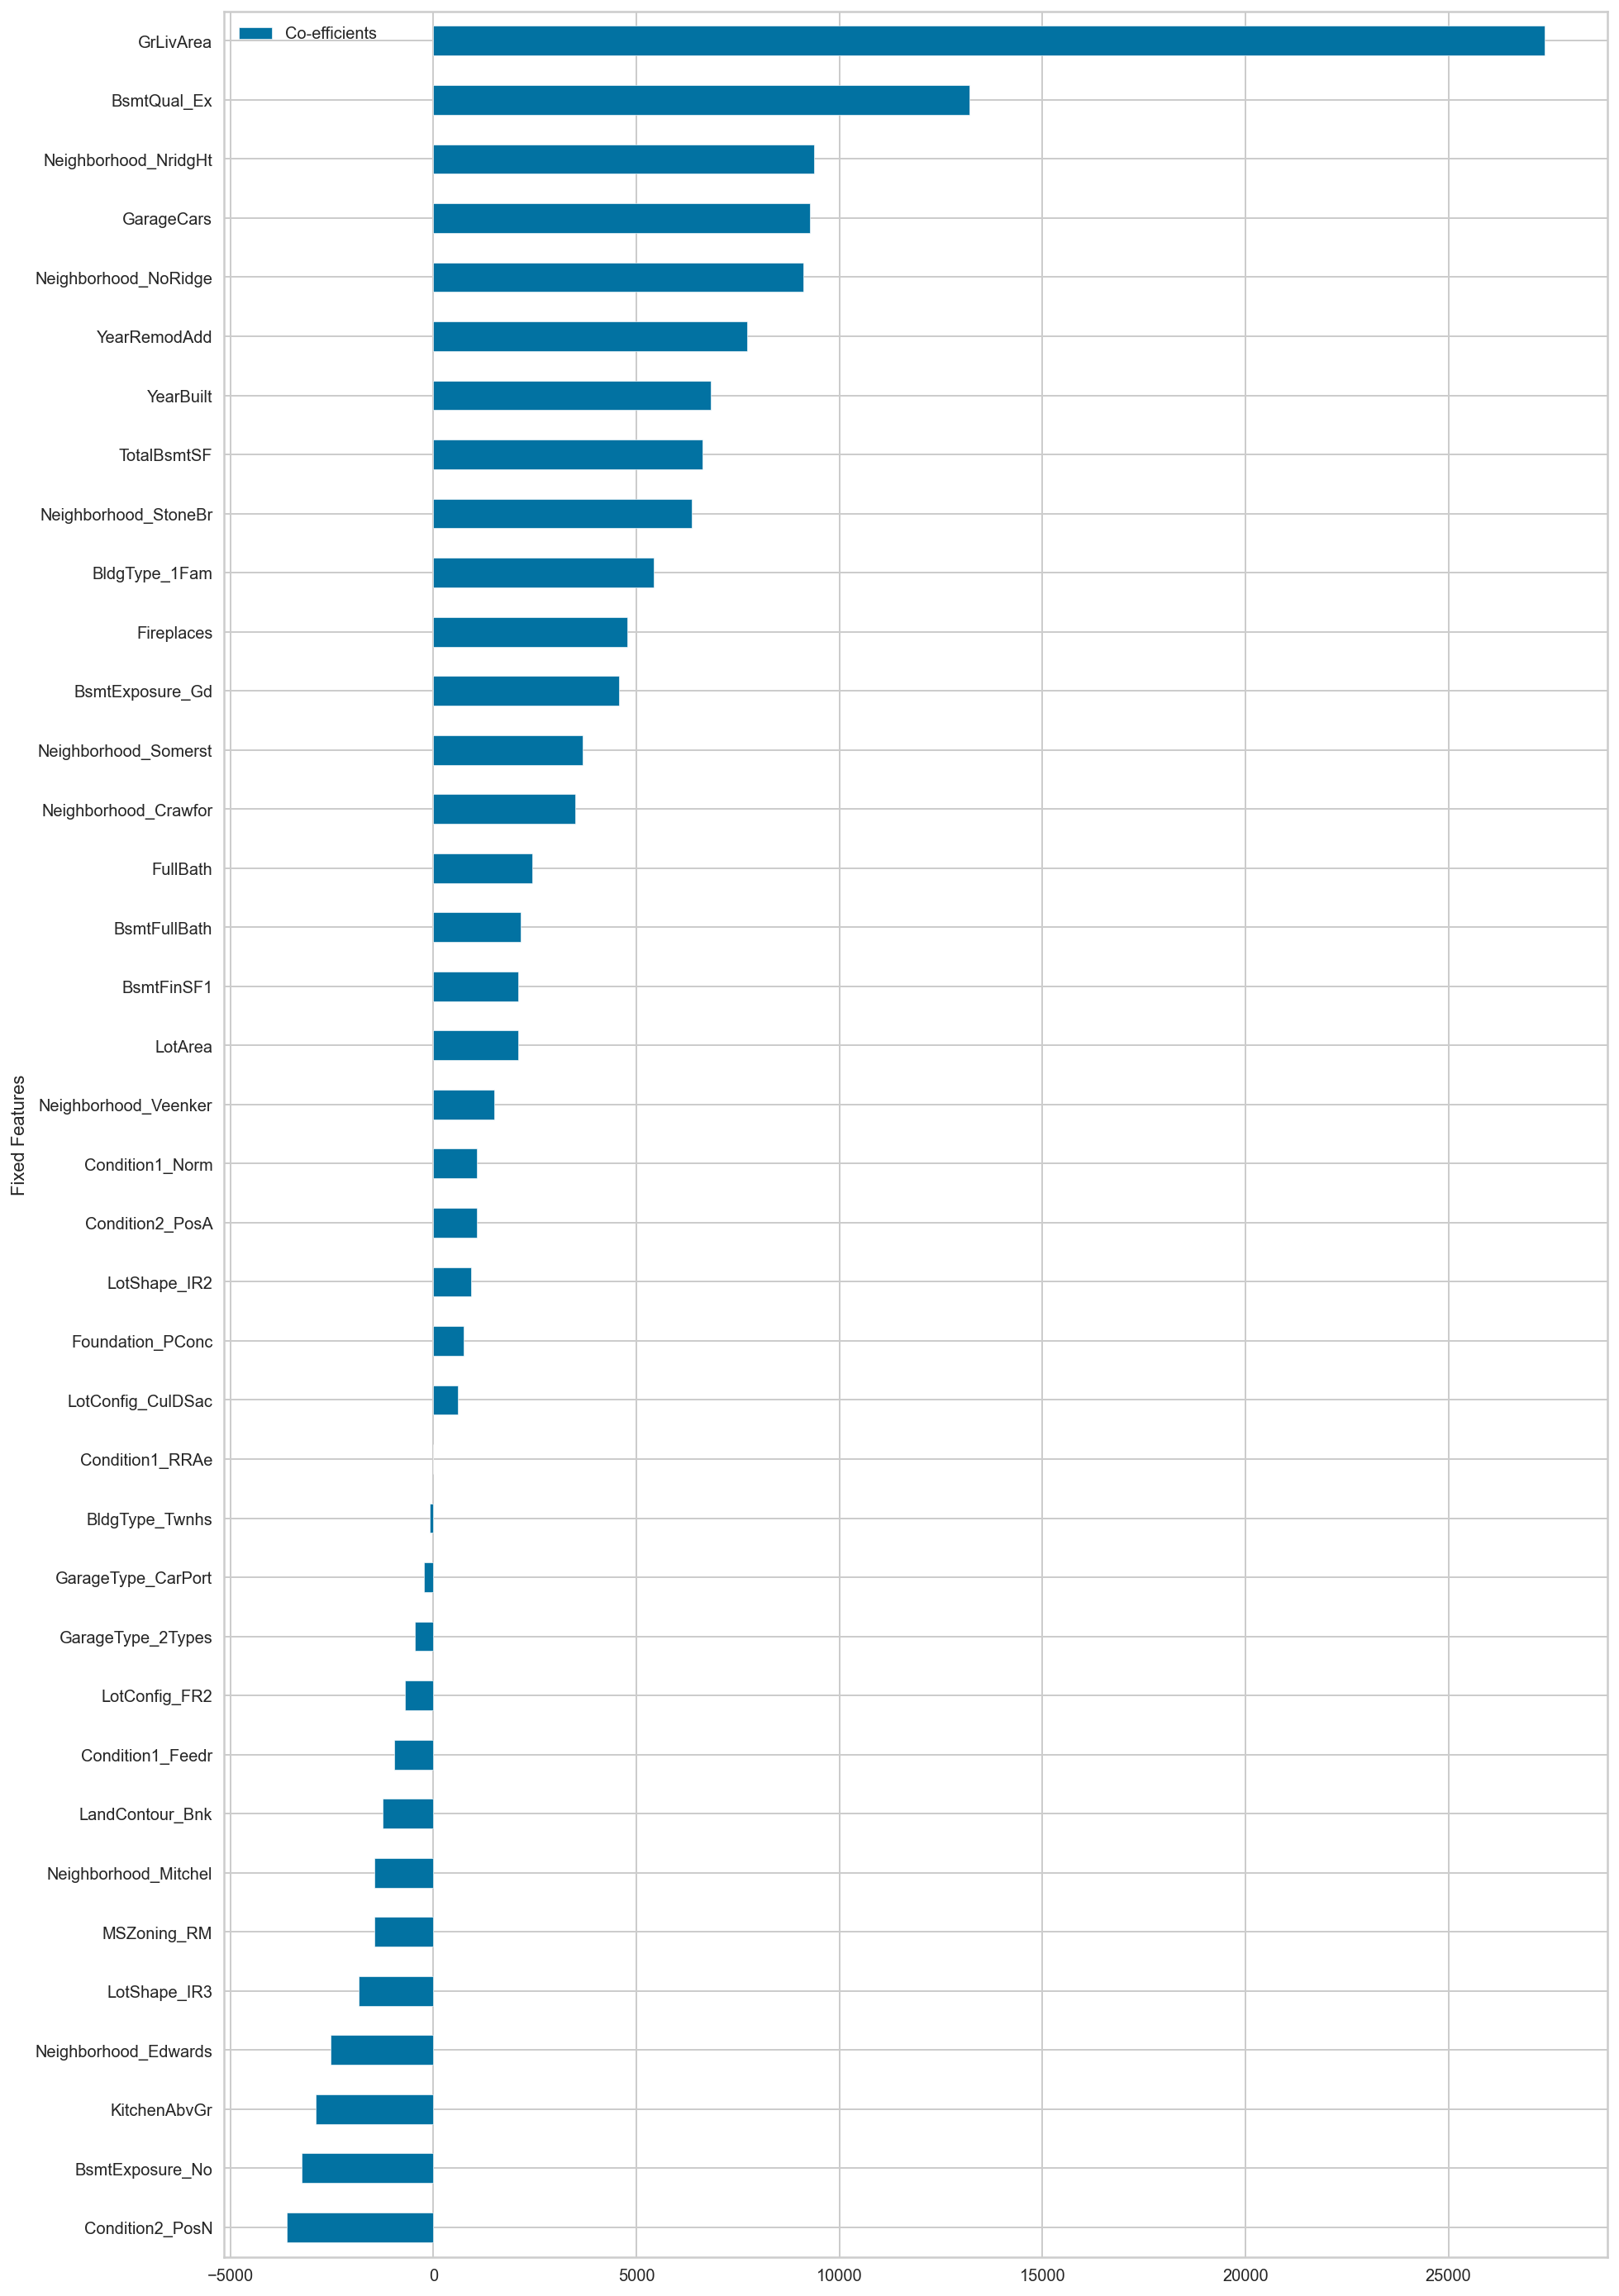

In [48]:
sorted_fixed_coef.sort_values('Co-efficients').plot(x='Fixed Features',
                                                   y=['Co-efficients'],
                                                   kind='barh', 
                                                   figsize=(15,25))

#### Top five fixed features are 'Ground Living Area', 'Year Remodelled', 'Garage Car Count', 'Year Built', 'Neighbourhood Location - Northridge Heights'.

Looking at the difference in `Sale Price` value between the different suburbs.

Text(0.5, 1.0, 'Median Price of Home by Neighborhood')

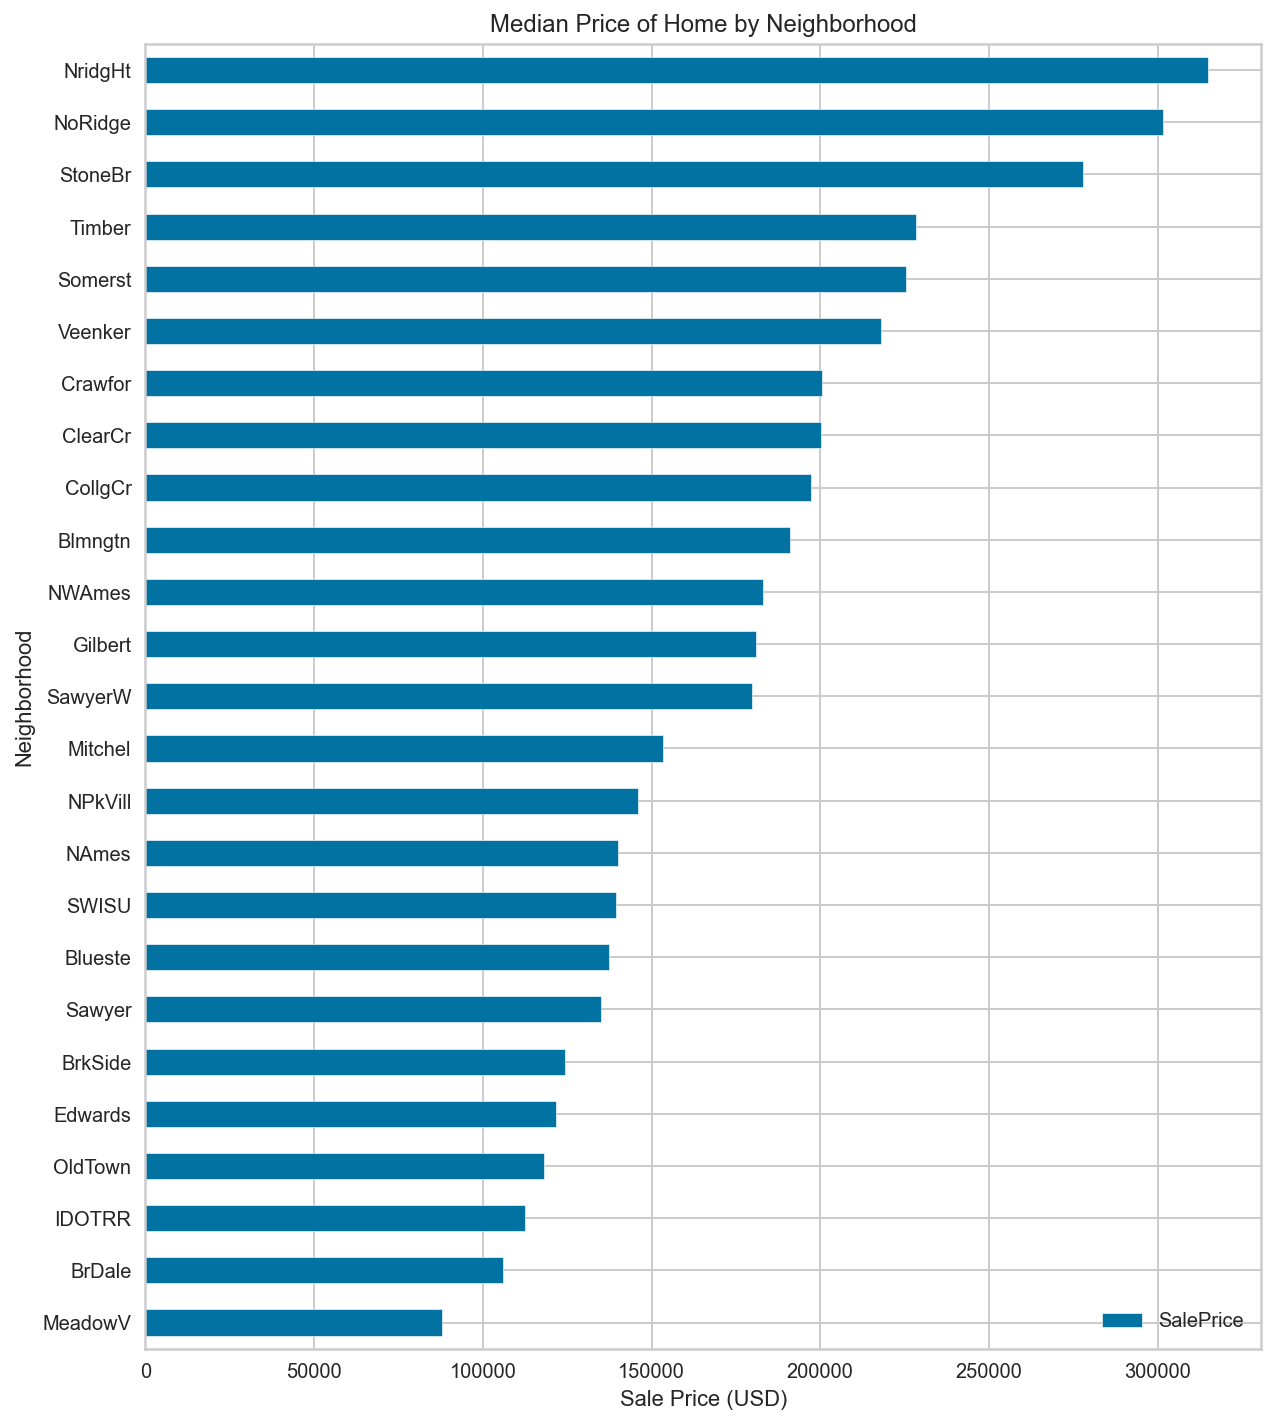

In [49]:
a = pd.DataFrame(house.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = True))
a.plot(figsize = (10,12),
       kind='barh',)
plt.xlabel('Sale Price (USD)')
plt.title('Median Price of Home by Neighborhood')

#### Extracting all the fixed feature names from the fixed features DataFrame. 

In [50]:
sorted_fixed_coef['Fixed Features'].values

array(['GrLivArea', 'BsmtQual_Ex', 'Neighborhood_NridgHt', 'GarageCars',
       'Neighborhood_NoRidge', 'YearRemodAdd', 'YearBuilt', 'TotalBsmtSF',
       'Neighborhood_StoneBr', 'BldgType_1Fam', 'Fireplaces',
       'BsmtExposure_Gd', 'Neighborhood_Somerst', 'Condition2_PosN',
       'Neighborhood_Crawfor', 'BsmtExposure_No', 'KitchenAbvGr',
       'Neighborhood_Edwards', 'FullBath', 'BsmtFullBath', 'BsmtFinSF1',
       'LotArea', 'LotShape_IR3', 'Neighborhood_Veenker', 'MSZoning_RM',
       'Neighborhood_Mitchel', 'LandContour_Bnk', 'Condition1_Norm',
       'Condition2_PosA', 'Condition1_Feedr', 'LotShape_IR2',
       'Foundation_PConc', 'LotConfig_FR2', 'LotConfig_CulDSac',
       'GarageType_2Types', 'GarageType_CarPort', 'BldgType_Twnhs',
       'Condition1_RRAe'], dtype=object)

#### Setting the `X_Train` `X-Test` indicies. 

In [52]:
lassoed_fixed_train = X_train[['GrLivArea', 'BsmtQual_Ex', 'Neighborhood_NridgHt', 'GarageCars',
       'Neighborhood_NoRidge', 'YearRemodAdd', 'YearBuilt', 'TotalBsmtSF',
       'Neighborhood_StoneBr', 'BldgType_1Fam', 'Fireplaces',
       'BsmtExposure_Gd', 'Neighborhood_Somerst', 'Condition2_PosN',
       'Neighborhood_Crawfor', 'BsmtExposure_No', 'KitchenAbvGr',
       'Neighborhood_Edwards', 'FullBath', 'BsmtFullBath', 'BsmtFinSF1',
       'LotArea', 'LotShape_IR3', 'Neighborhood_Veenker', 'MSZoning_RM',
       'Neighborhood_Mitchel', 'LandContour_Bnk', 'Condition1_Norm',
       'Condition2_PosA', 'Condition1_Feedr', 'LotShape_IR2',
       'Foundation_PConc', 'LotConfig_FR2', 'LotConfig_CulDSac',
       'GarageType_2Types', 'GarageType_CarPort', 'BldgType_Twnhs',
       'Condition1_RRAe']]

In [51]:
lassoed_fixed_test = X_test[['GrLivArea', 'BsmtQual_Ex', 'Neighborhood_NridgHt', 'GarageCars',
       'Neighborhood_NoRidge', 'YearRemodAdd', 'YearBuilt', 'TotalBsmtSF',
       'Neighborhood_StoneBr', 'BldgType_1Fam', 'Fireplaces',
       'BsmtExposure_Gd', 'Neighborhood_Somerst', 'Condition2_PosN',
       'Neighborhood_Crawfor', 'BsmtExposure_No', 'KitchenAbvGr',
       'Neighborhood_Edwards', 'FullBath', 'BsmtFullBath', 'BsmtFinSF1',
       'LotArea', 'LotShape_IR3', 'Neighborhood_Veenker', 'MSZoning_RM',
       'Neighborhood_Mitchel', 'LandContour_Bnk', 'Condition1_Norm',
       'Condition2_PosA', 'Condition1_Feedr', 'LotShape_IR2',
       'Foundation_PConc', 'LotConfig_FR2', 'LotConfig_CulDSac',
       'GarageType_2Types', 'GarageType_CarPort', 'BldgType_Twnhs',
       'Condition1_RRAe']]

#### Fitting the lassoed fixed features, and scoring the regression. 

In [53]:
lcv_fixed_lassoed = LassoCV(cv=lassoed_fixed_train.shape[0]-1, n_jobs=-1)

lcv_fixed_lassoed.fit(lassoed_fixed_train, y_train)
print((lcv_fixed_lassoed.score(lassoed_fixed_test,y_test))*100,'% of the variance can be explained by the remaining fixed features extracted by the Lasso Regession Model.')

76.03101651288665 % of the variance can be explained by the remaining fixed features extracted by the Lasso Regession Model.


#### Plotting the variance between the predicted and actual `SalePrice`, as the residual values are the non-fixed/renovatable features of the properties. 

Text(0.5, 1.0, 'Variance')

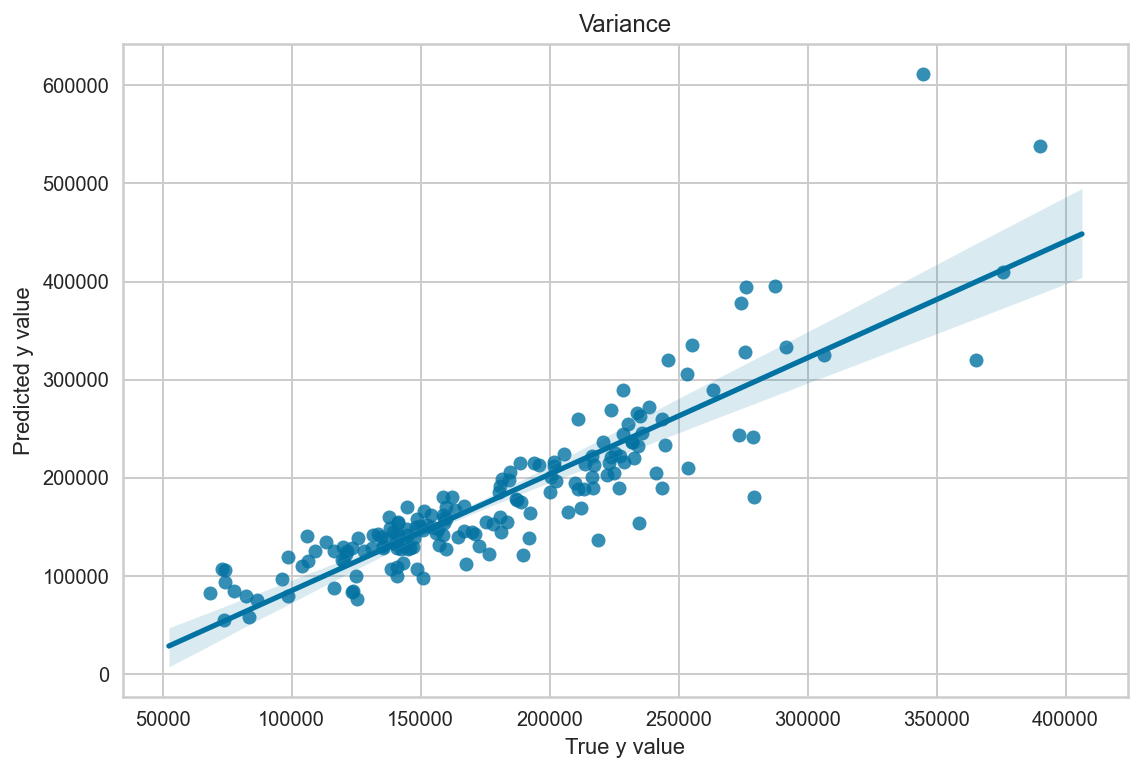

In [54]:
plt.figure(figsize=(9, 6))
ax = sns.regplot(x=lcv_fixed_lassoed.predict(lassoed_fixed_test), y=y_test)
ax.set_xlabel('True y value')
ax.set_ylabel('Predicted y value')
ax.set_title('Variance')

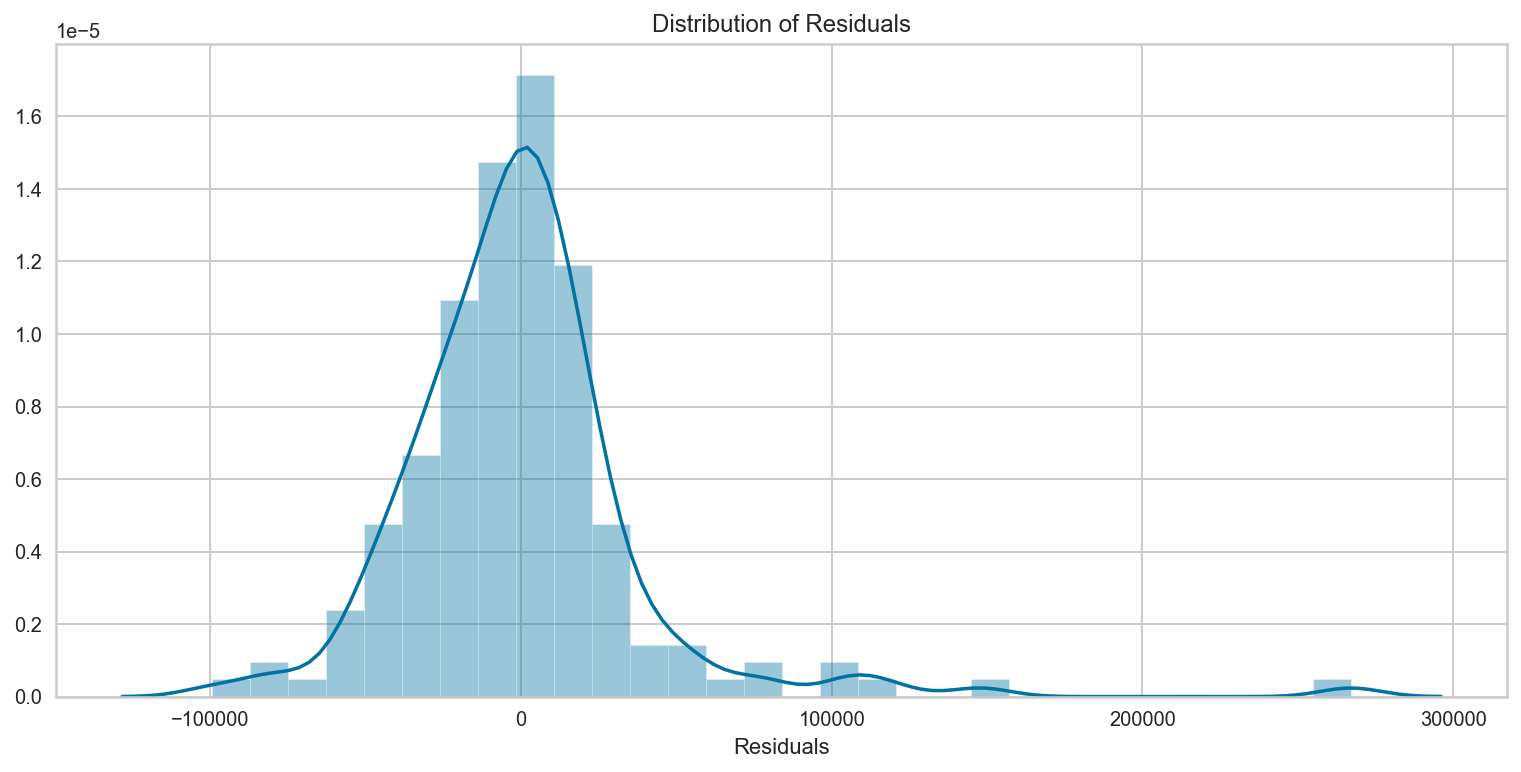

In [55]:
residuals = y_test - lcv_fixed_lassoed.predict(lassoed_fixed_test)

plt.figure(figsize=(13, 6))
ax = sns.distplot(residuals)
ax.set_xlabel('Residuals')
ax.set_title('Distribution of Residuals');

Residuals have a normal distribution. 

## Determining any value of *non-fixed* property characteristics unexplained by the *fixed* ones.

---

Now that we have a model that estimates the price of a house based on its static characteristics, we can;

1. Estimate the impacts of the non-fixed characteristics in dollars. 
2. The effects will be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics.

---

### Renovatable Feature Modelling Using Manually Selected Features

In [56]:
fixed.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,MiscFeature
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,1,3,1,8,0,Attchd,2003.0,2,548,NaN
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,0,3,1,6,1,Attchd,1976.0,2,460,NaN
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,1,3,1,6,1,Attchd,2001.0,2,608,NaN
3,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0,3,1,7,1,Detchd,1998.0,3,642,NaN
4,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,1,4,1,9,1,Attchd,2000.0,3,836,NaN


In [57]:
renovatable = house.drop(fixed,axis=1)
# house["SalePrice"]=np.log1p(house["SalePrice"])
y = house['SalePrice']

In [58]:
renovatable.columns

Index(['Id', 'MSSubClass', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [59]:
renovatable.drop(['Id', 'MSSubClass', 'SaleType', 'SaleCondition', 'MasVnrArea', 'SalePrice'], axis=1, inplace=True)

#### Creating dummies of categorical features. 

In [60]:
reno_dummies = pd.get_dummies(renovatable.select_dtypes(include=['object']), dummy_na=True, drop_first=True)

In [61]:
long_reno = pd.concat([renovatable,reno_dummies], axis=1, sort=True)

In [62]:
long_reno.drop(['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence'], axis=1, inplace=True)

#### As before we split the houses into year sold prior to and on or after 2010. 

In [63]:
train_index = house[house['YrSold'] < 2010].index
test_index = house[house['YrSold'] >= 2010].index

X_reno_train = long_reno.loc[train_index, :]
X_reno_test = long_reno.loc[test_index, :]
y_reno_train = house.loc[train_index, 'SalePrice'].values
y_reno_test = house.loc[test_index, 'SalePrice'].values

In [64]:
ss = StandardScaler()
Xs_reno_train = ss.fit_transform(X_reno_train)
Xs_reno_test = ss.transform(X_reno_test)

In [65]:
lr_reno = LinearRegression(n_jobs=-1)

lr_reno.fit(X_reno_train, y_reno_train)
lr_reno.score(X_reno_test, y_reno_test)

0.751707533576734

A simple linear regression on the reonvatable features, explains 75.170% of the variance in the `Sale Price` for properties sold pre-2010.

Text(0.5, 1.0, 'Actual vs. Predicted Home Values - Renovatable Features')

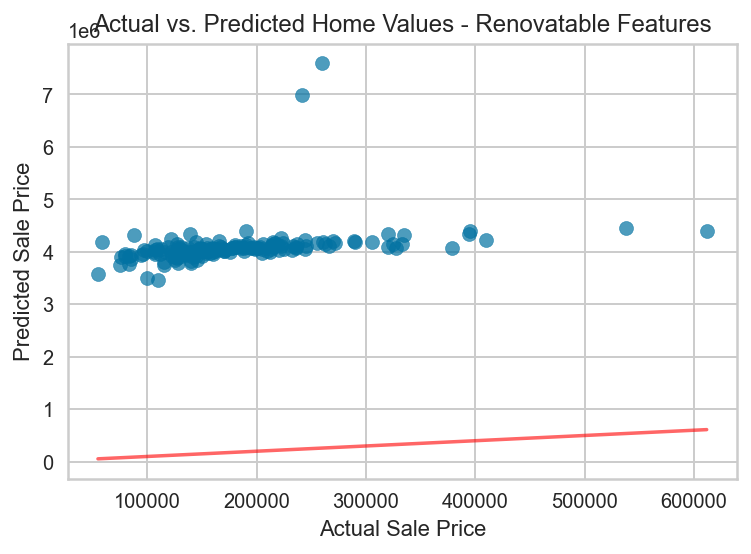

In [66]:
plt.plot([min(y_reno_test), max(y_reno_test)], [min(y_reno_test), max(y_reno_test)], color='red', alpha=0.6)
plt.scatter(y_reno_test, lr_reno.predict(Xs_reno_test), alpha = .7)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Home Values - Renovatable Features')

****Feature Selection Using LassoCV****

In [69]:
lcv_reno = LassoCV(cv=Xs_reno_train.shape[0]-1, n_jobs=-1)

lcv_reno.fit(Xs_reno_train,y_reno_train)
print((lcv_reno.score(Xs_reno_test,y_reno_test))*100,'% of the variance in the `Sale Price` for properties sold pre-2010, can be explained by the Lasso Features.')

72.55396938666136 % of the variance in the `Sale Price` for properties sold pre-2010, can be explained by the Lasso Features.


In [76]:
long_reno.columns

Index(['OverallQual', 'OverallCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold',
       ...
       'PavedDrive_P', 'PavedDrive_Y', 'PavedDrive_nan', 'PoolQC_Fa',
       'PoolQC_Gd', 'PoolQC_nan', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw',
       'Fence_nan'],
      dtype='object', length=142)

In [77]:
reno_coef = pd.DataFrame({'Features':long_reno.columns, 'Co-efficients': lcv_reno.coef_, "Absolute Co-efficients":np.abs(lcv_reno.coef_)})
reno_coef[reno_coef['Absolute Co-efficients']!=0].sort_values('Absolute Co-efficients', ascending=False).head(15)

,Features,Co-efficients,Absolute Co-efficients
0,OverallQual,36645.242903,36645.242903
105,KitchenQual_TA,-17881.055584,17881.055584
104,KitchenQual_Gd,-13692.962157,13692.962157
62,ExterQual_TA,-11780.309953,11780.309953
118,FireplaceQu_nan,-9892.876885,9892.876885
7,PoolArea,9601.857323,9601.857323
136,PoolQC_Gd,-8776.540720,8776.540720
2,WoodDeckSF,7831.846056,7831.846056
61,ExterQual_Gd,-7075.939854,7075.939854
23,RoofMatl_WdShngl,6549.360439,6549.360439


In [78]:
house['KitchenQual'].value_counts()

TA    727
Gd    586
Ex    100
Fa     37
Name: KitchenQual, dtype: int64

In [79]:
house['ExterQual'].value_counts()

TA    899
Gd    488
Ex     52
Fa     11
Name: ExterQual, dtype: int64

In [80]:
house['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

Kitchen quality is very important. Whereas, the exterior quality is very skewed and pool quality has too little data.

****Combine fixed model with Kitchen Features****

In [81]:
top5_fixed_coefficients = long_fixed[['GrLivArea', 'YearRemodAdd', 'GarageCars', 'YearBuilt',
       'Neighborhood_NridgHt', 'Fireplaces', 'BsmtQual_Ex',
       'Neighborhood_Crawfor', 'BsmtFullBath', 'Neighborhood_StoneBr']]

In [82]:
fixed_coefficients = long_fixed[['GrLivArea', 'YearRemodAdd', 'GarageCars', 'YearBuilt',
       'Neighborhood_NridgHt', 'Fireplaces', 'BsmtQual_Ex',
       'Neighborhood_Crawfor', 'BsmtFullBath', 'Neighborhood_StoneBr',
       'Neighborhood_Edwards', 'MSZoning_RM', 'Neighborhood_Somerst',
       'FullBath', 'Condition2_PosN', 'KitchenAbvGr', 'Neighborhood_NoRidge',
       'TotalBsmtSF', 'LotArea', 'BsmtExposure_Gd', 'TotRmsAbvGrd',
       'BldgType_1Fam', 'LotShape_IR3', 'GarageType_Attchd',
       'BsmtExposure_nan', 'BldgType_Twnhs', 'Neighborhood_MeadowV',
       'BsmtExposure_No', 'GarageType_nan', 'Condition1_Feedr',
       'Condition2_PosA', 'HouseStyle_2Story', 'Foundation_PConc',
       'LandSlope_Sev', 'Neighborhood_Veenker', 'Neighborhood_Mitchel',
       'GarageType_CarPort', 'LandContour_Bnk', 'HalfBath', 'BsmtQual_Gd',
       'Neighborhood_Gilbert', 'Condition1_Artery', 'Condition1_RRAe',
       'BsmtQual_Fa', 'GarageType_2Types', 'LotConfig_CulDSac', 'BsmtFinSF1',
       'BldgType_TwnhsE', 'LotShape_IR2', 'Neighborhood_Sawyer',
       'LotConfig_FR2', 'BsmtHalfBath', 'Neighborhood_OldTown',
       'Foundation_Slab', 'BldgType_2fmCon', 'LotFrontage', 'Alley_Pave',
       'BsmtQual_nan', 'LandContour_HLS', 'Condition2_Norm',
       'Foundation_BrkTil', 'GarageArea', 'MiscFeature_TenC',
       'HouseStyle_1.5Unf', 'LowQualFinSF', 'BsmtExposure_Av',
       'Neighborhood_BrkSide', 'Neighborhood_Timber', 'Condition1_Norm',
       'Condition1_PosN', 'GarageType_BuiltIn']]

In [84]:
kitch_dummies = pd.get_dummies(house['KitchenQual'], prefix='KitchenQual')

In [85]:
kitch_dummies

,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1455,0,0,0,1
1456,0,0,0,1
1457,0,0,1,0
1458,0,0,1,0


In [86]:
combo = kitch_dummies.merge(fixed_coefficients, how='right', left_index=True, right_index=True)

In [87]:
combo5 = kitch_dummies.merge(top5_fixed_coefficients, how='right', left_index=True, right_index=True)

In [88]:
combo_full = combo.merge(house[['YrSold', 'SalePrice']], how='left', left_index=True, right_index=True)

In [89]:
combo_full5 = combo.merge(house[['YrSold', 'SalePrice']], how='left', left_index=True, right_index=True)

In [90]:
test = combo_full[combo_full['YrSold'] < 2010]
train = combo_full[combo_full['YrSold'] >= 2010]

X_combo_train = train.iloc[:, train.columns != 'SalePrice'] 
y_combo_train = train['SalePrice']
X_combo_test = test.iloc[:, train.columns != 'SalePrice']
y_combo_test = test['SalePrice']

In [91]:
test5 = combo_full5[combo_full5['YrSold'] < 2010]
train5 = combo_full5[combo_full5['YrSold'] >= 2010]

X_combo_train5 = train5.iloc[:, train5.columns != 'SalePrice'] 
y_combo_train5 = train5['SalePrice']
X_combo_test5 = test5.iloc[:, train5.columns != 'SalePrice']
y_combo_test5 = test5['SalePrice']

In [93]:
lr_combo5 = LinearRegression()
lr_combo5.fit(X_combo_train5, y_combo_train5)

print (lr_combo5.score(X_combo_test5, y_combo_test5))

a = pd.DataFrame(zip(X_combo_train5.columns, lr_combo5.coef_), columns = ['variance', 'beta'])
a['abs_beta'] = abs(a['beta'])

print (a[a['variance'] == 'KitchenQual_Ex'])
print (a[a['variance'] == 'KitchenQual_Gd'])
print (a[a['variance'] == 'KitchenQual_Ta'])
print (a[a['variance'] == 'KitchenQual_Fa'])

0.707132047179398
         variance         beta     abs_beta
0  KitchenQual_Ex  41878.65673  41878.65673
         variance          beta      abs_beta
2  KitchenQual_Gd -18357.419701  18357.419701
Empty DataFrame
Columns: [variance, beta, abs_beta]
Index: []
         variance         beta     abs_beta
1  KitchenQual_Fa -3472.213279  3472.213279


In [94]:
lr_combo = LinearRegression()
lr_combo.fit(X_combo_train, y_combo_train)

print (lr_combo.score(X_combo_test, y_combo_test))

a = pd.DataFrame(zip(X_combo_train.columns, lr_combo.coef_), columns = ['variance', 'beta'])
a['abs_beta'] = abs(a['beta'])

print (a[a['variance'] == 'KitchenQual_Ex'])
print (a[a['variance'] == 'KitchenQual_Gd'])
print (a[a['variance'] == 'KitchenQual_Ta'])
print (a[a['variance'] == 'KitchenQual_Fa'])

0.707132047179398
         variance         beta     abs_beta
0  KitchenQual_Ex  41878.65673  41878.65673
         variance          beta      abs_beta
2  KitchenQual_Gd -18357.419701  18357.419701
Empty DataFrame
Columns: [variance, beta, abs_beta]
Index: []
         variance         beta     abs_beta
1  KitchenQual_Fa -3472.213279  3472.213279


Text(0.5, 1.0, 'Actual vs. Predicted Home Price with Kitchen Quality')

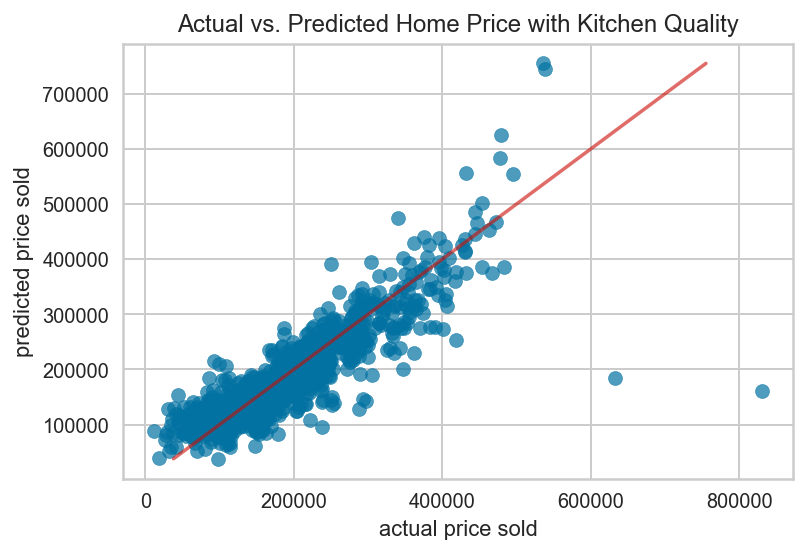

In [95]:
plt.plot([min(y_combo_test), max(y_combo_test)], [min(y_combo_test), max(y_combo_test)], c = 'r', alpha = .6)
plt.scatter(lr_combo.predict(X_combo_test), y_combo_test, alpha = .7)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted Home Price with Kitchen Quality')

### Conclusions

The r-squared score decreased from 0.886 to 0.707 when including the kitchen quality data with the impactful fixed features.

The absolute coefficients of the Kitchen Quality dummy variable show us how much the expected Sale Price would increase by improving the Kitchen level. 

Price Differences:

- Excellent: $41,878.66     

- Good: $18,357.42

- Typical / Average: $0.00

- Fair: -$3,472.21

## Looking at what property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

---

- Need to determine which features predict the `Abnorml` category in the `SaleCondition` feature.

In [155]:
abnormal_house_df = house

Normalizing the `SaleCondition` category so we can see the rough frequency of the different categories as a percentage.

In [156]:
abnormal_house_df.SaleCondition.value_counts(normalize=True)

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

`Abnorml` Sales are only 6.62% of the total sales. Using Logisitic Regression to identify the features that create an Abnormal Sale we will are required to 'over' and 'under' sample. 

First we need to binarise the `SaleCondition` with `Abnorml` as 1 and the remaining categories as 0.

In [157]:
abnormal_house_df['abnormal_flagging'] = abnormal_house_df['SaleCondition'].apply(lambda x: 1 if x == 'Abnorml' else 0)
target_ab = abnormal_house_df['abnormal_flagging']

In [158]:
abnormal_house_df.drop(columns=['SaleCondition'], axis=1, inplace=True)

In [159]:
abnormal_house_df.abnormal_flagging.value_counts(normalize=True)

0    0.930822
1    0.069178
Name: abnormal_flagging, dtype: float64

Need to upscale the `Abnormal Flagging` column to remove skewness.

In [160]:
abnormal_house_df.set_index('Id', inplace=True)

Train, Test split the data before over/under sampling to avoid duplication of the same data in each set. 

In [163]:
X_train, X_test, y_train, y_test = train_test_split(abnormal_house_df, target_ab)

In [164]:
# OverSampling
over = RandomOverSampler(sampling_strategy=0.3)
house_ab, y_ab = over.fit_resample(X_train, y_train)
# UnderSampling
under = RandomUnderSampler(sampling_strategy=0.2)
house_ab, y_ab = under.fit_resample(X_train, y_train)

In [166]:
house_ab.shape

(444, 80)

In [167]:
y_ab.shape

(444,)

In [171]:
feature_ab = FeatureSelector(data=house_ab, labels=y_ab)

In [190]:
feature_ab.identify_zero_importance(task='classification',
                                   eval_metric='auc')

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.398566
Training until validation scores don't improve f

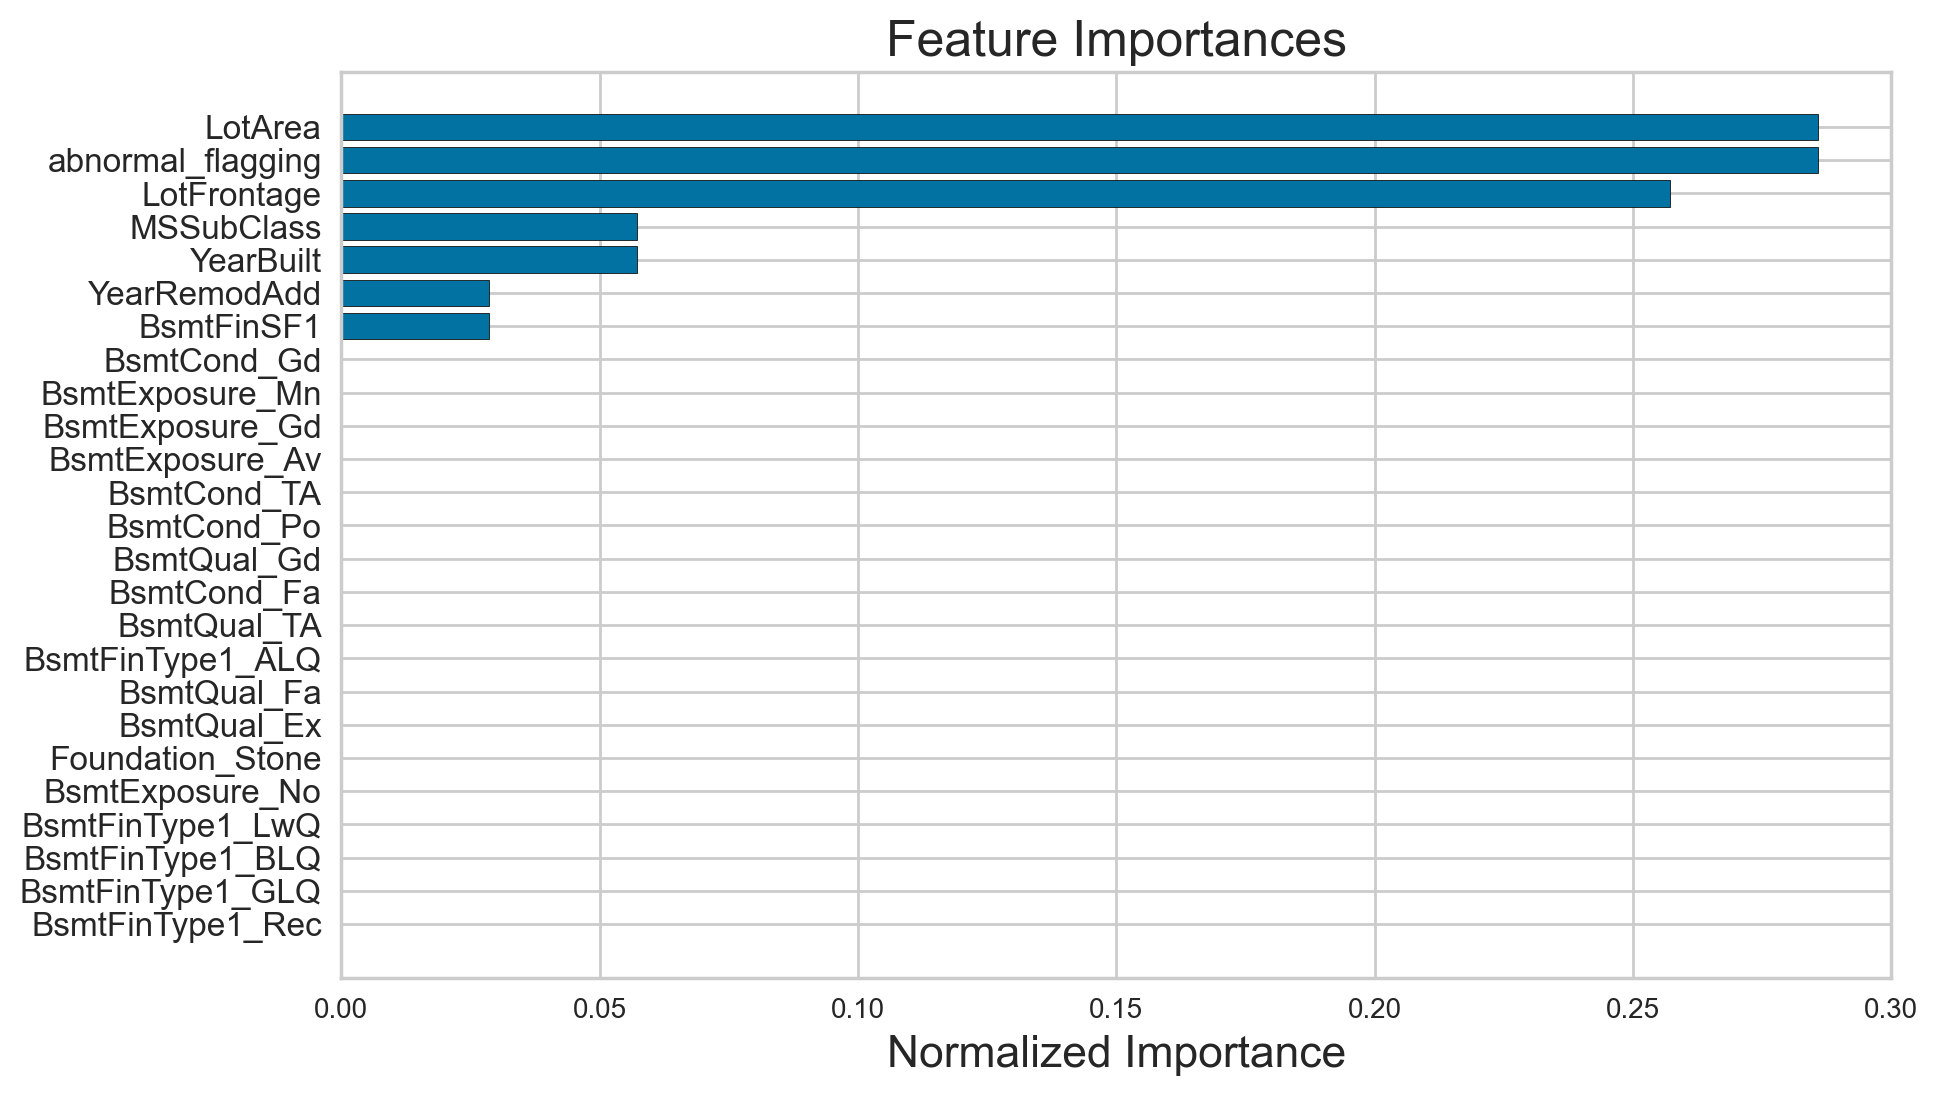

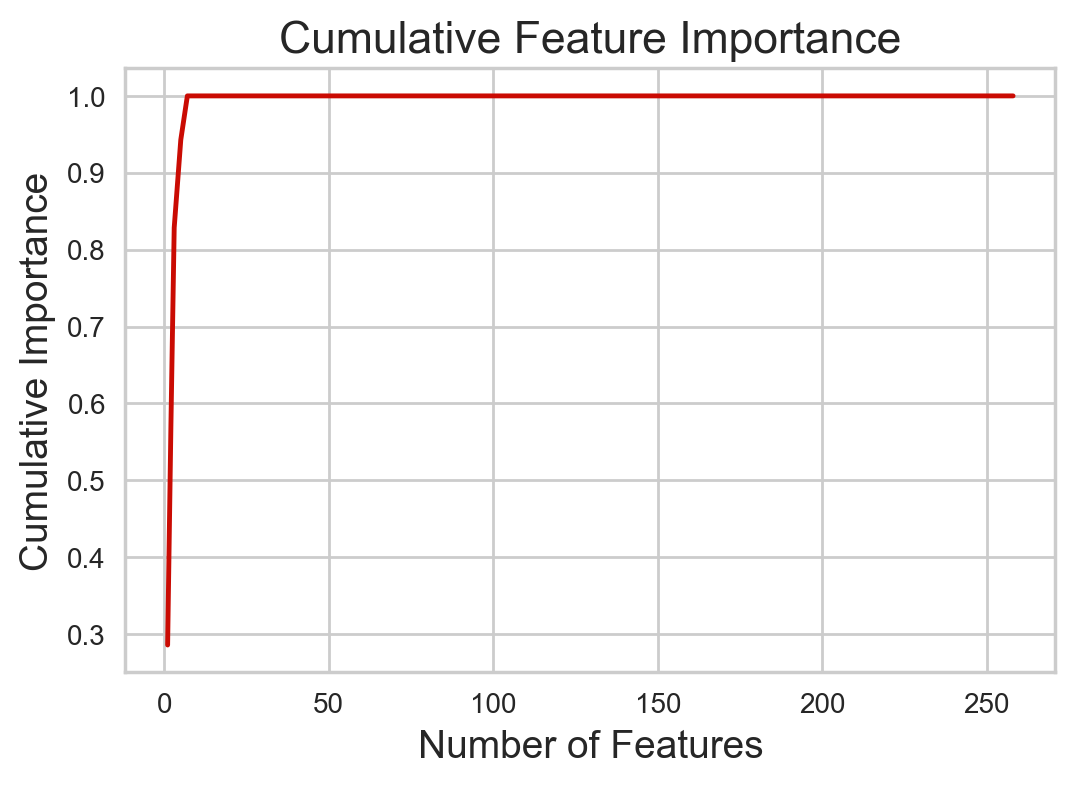

In [192]:
feature_ab.plot_feature_importances(plot_n=25)